# An overview of MetaPhlan and HuMANN results

This track uses the dataset from [Lokmer 2019](https://pubmed.ncbi.nlm.nih.gov/30726303/).

> In this notebook there is only a draft to import data and visualise the imported datasets, but it's very open for you to play with.

In [296]:
# import libraries 
import pandas as pd
import seaborn as sns
import re

## Hostile contamination

We ran hostile to remove human reads. In the scripts directory you can also find some **scripts** to summarise the results of this step.
We are not plotting here the results but you can try!

## Metadata

Let's import the metadata and try to format in a more useful way

In [297]:
# Use remote files
metadata_url = 'https://raw.githubusercontent.com/quadram-institute-bioscience/biobakery-2024/main/datasets/lokmer.csv'
metadataFullDf = pd.read_csv(metadata_url)
metadataFullDf.set_index('run_accession', inplace=True)
cols = ['sample_title', 'sample_description']

metadataDf = metadataFullDf[cols]

# Extracting the columns from the sample_description column
# using regular expressions
extracted_data = metadataDf['sample_description'].str.extract(r'Faecal metagenome of a (\d+) old (female|male) from ([^,]+), (\w+)')
extracted_data.columns = ['age', 'sex', 'location', 'country']

# Concatenating the extracted columns back to the original DataFrame
metadataDf = pd.concat([metadataDf, extracted_data], axis=1)
metadataDf.drop('sample_description', axis=1, inplace=True)

# We extracted pieces of strings, but age is numbers
metadataDf['age'] = pd.to_numeric(metadataDf['age'])
# Display the DataFrame
metadataDf.head()
 

,sample_title,age,sex,location,country
run_accession,,,,,
ERR2619707,Cam2013_BAB01,61,male,Bandevouri,Cameroon
ERR2619708,Cam2013_BAB04,41,male,Bidou,Cameroon
ERR2619709,Cam2013_BAB06,49,female,Bidou,Cameroon
ERR2619710,Cam2013_BAB07,57,male,Bidou,Cameroon
ERR2619711,Cam2013_BAB08,53,female,Bidou,Cameroon


It's always a good idea to start exploring the metadata, checking for missing values etc. In our case we didn't have any, but we can now see how the dataset looks like

In [298]:
# How many % females?
female_ratio = (metadataDf['sex'] == 'female').mean() * 100
female_ratio


43.859649122807014

In [299]:
# How many cities? Display country, percentage in descending order
city_counts = metadataDf['location'].value_counts(normalize=True) * 100
city_counts

location
Ebodié          33.333333
Bandevouri      17.543860
Afan Essokié    15.789474
Akak            14.035088
Bidou           10.526316
Makouvé          5.263158
Ndtoua           3.508772
Name: proportion, dtype: float64

### Plotting age distribution

Let's make our first plot using the "age" column

[Text(0.5, 1.0, 'Age Distribution'),
 Text(0.5, 0, 'Age'),
 Text(0, 0.5, 'Frequency')]

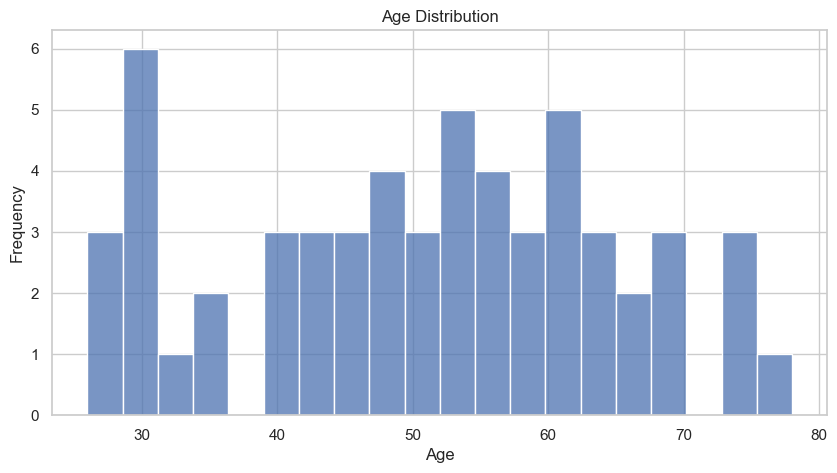

In [300]:

# First, let's sort age
metadataDf = metadataDf.sort_values(by='age')
 

# Plotting the histogram
 
sns.histplot(metadataDf['age'], kde=False, bins=20).set(
    title='Age Distribution', xlabel='Age', ylabel='Frequency')
 


In [301]:
# Can we now arbitrarily bin the samples in three groups after seeing the plot?
young_adults = (metadataDf['age'] < 40).sum()

senior = (metadataDf['age'] > 60).sum()

other = len(metadataDf) - young_adults - senior
young_adults, senior, other

(12, 17, 28)

## Import the metaphlan table

In [302]:
mpa_url = 'https://raw.githubusercontent.com/quadram-institute-bioscience/biobakery-2024/main/datasets/lokmer_metaphlan.tsv.gz'
mpaDf = pd.read_csv(mpa_url, compression='gzip', sep='\t', header=1)
mpaDf.set_index('clade_name', inplace=True)
mpaDf.head()

,ERR2619707,ERR2619708,ERR2619709,ERR2619710,ERR2619711,ERR2619712,ERR2619713,ERR2619714,ERR2619715,ERR2619716,...,ERR2619754,ERR2619755,ERR2619756,ERR2619757,ERR2619758,ERR2619759,ERR2619760,ERR2619761,ERR2619762,ERR2619763
clade_name,,,,,,,,,,,,,,,,,,,,,
UNCLASSIFIED,38.481370,34.380640,21.611820,25.752700,27.260530,21.946400,32.934470,16.012430,23.909180,24.084470,...,21.910020,33.182930,33.482040,26.430190,31.012000,20.879670,18.338990,23.488640,25.466750,44.321980
k__Bacteria,61.493694,65.522322,78.351099,74.247297,72.676965,78.053603,67.065527,83.978157,75.899631,75.894056,...,77.656538,66.732659,66.517962,73.569805,68.987997,79.120334,81.156355,76.431814,74.533254,55.678021
k__Archaea,0.024940,0.097038,0.037078,0.000000,0.051427,0.000000,0.000000,0.009415,0.191186,0.020543,...,0.433446,0.027241,0.000000,0.000000,0.000000,0.000000,0.504657,0.077078,0.000000,0.000000
k__Bacteria|p__Firmicutes,39.921779,19.063769,36.513996,33.345835,41.810669,23.407284,0.863958,41.376990,17.609538,31.591460,...,32.662862,25.145882,12.517982,20.454870,11.506777,5.703286,25.569859,31.798551,29.166621,13.613404
k__Bacteria|p__Bacteroidetes,19.615985,35.963950,15.801802,34.109995,15.755857,32.392495,0.001274,31.638438,25.424658,29.919314,...,28.922242,11.421877,49.735201,44.033875,38.770868,64.962604,39.369901,18.780548,42.871431,10.132971


Now we have two tables. Let's check the metadata fits the abundance table.

In [303]:
# the columns of mpaDf are the samples, that are the same as the index of metadataDf. 
# (order does not matter)
set(metadataDf.index) == set(mpaDf.columns)

True

Now, let's compare the average and standard deviation of the
percentage of UNCLASSIFIED in each category: young_adults, senior, other

In [304]:
#Now, let's compare the average and standard deviation of the
#percentage of UNCLASSIFIED in each category: young_adults, senior, other

# First, we need to extract the UNCLASSIFIED row
unclassified = mpaDf.loc['UNCLASSIFIED']

# Now, we can calculate the average and standard deviation
# of the percentage of UNCLASSIFIED in each category. UNCLASSIFIED is already a percentage

young_adults_unclassified = unclassified[metadataDf.loc[unclassified.index, 'age'] < 40]
senior_unclassified = unclassified[metadataDf.loc[unclassified.index, 'age'] > 60]
other_unclassified = unclassified[metadataDf.loc[unclassified.index, 'age'].between(40, 60)]

print(f"<40:\t{young_adults_unclassified.mean()}\t± {young_adults_unclassified.std()}")
print(f"40-60:\t{other_unclassified.mean()}\t± {other_unclassified.std()}")
print(f">60:\t{senior_unclassified.mean()}\t± {senior_unclassified.std()}")


<40:	30.740891666666666	± 9.92918668956035
40-60:	27.947001071428577	± 7.563895038003625
>60:	28.673829411764704	± 6.58709526630334


If you observe the clade names, you will notice that they are provided at different taxonomic levels.
Let's check the sum of each column: we dont expect it to be 100.

<Axes: >

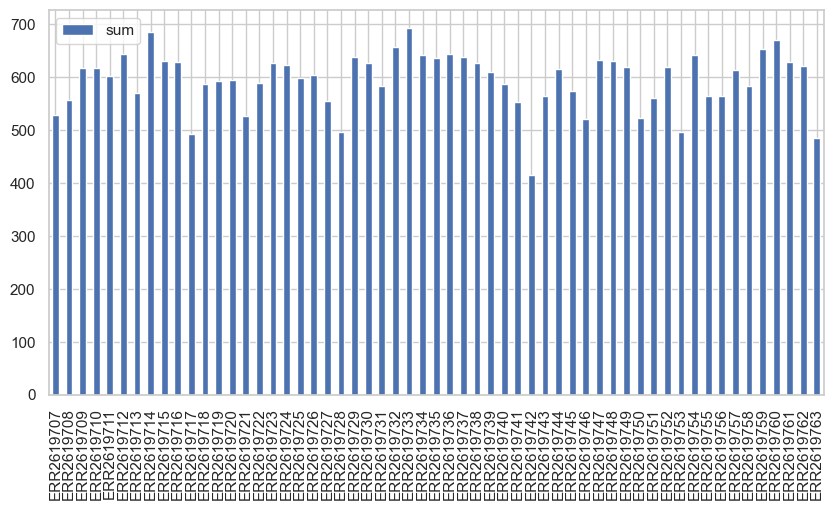

In [305]:
# Print the sum of all columns
mpaDf.sum().to_frame().set_axis(['sum'], axis=1).plot(kind='bar')
  

What if we want an overview at the genus level?

<Axes: >

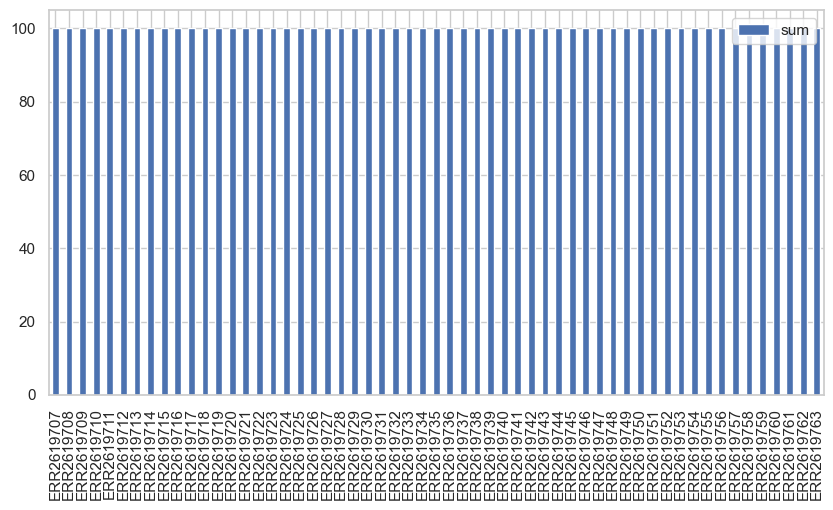

In [306]:
def string_to_rank(s):
    """
    Convert a clade_name like k__Bacteria|p__Firmicutes|c__CFGB76578|o__OFGB76578|f__FGB76578|g__GGB79648
    to a rank, in this case "genus"
    """
    return s.split('|')[-1].split('__')[0].lower()

def last_rank(s):
    return s.split('|')[-1].split('__')[1] if '__' in s else s

# Convert the index to ranks
ranks = mpaDf.index.map(string_to_rank)
mpaSpeciesDf = mpaDf.copy()

# Keep only rows with rank "s" or "unclassified"
mpaSpeciesDf = mpaSpeciesDf[ranks.isin(['s', 'unclassified'])]

mpaSpeciesDf.index = mpaSpeciesDf.index.map(last_rank)
# Now the sum should be 100%: all genera detected plus unclassified
# Let's see the average and stderr of the sum mpaSpeciesDf.sum(). 
mpaSpeciesDf.sum().to_frame().set_axis(['sum'], axis=1).plot(kind='bar')

What are the top 10 species in this dataset?


In [307]:
# Print the top 10 species (clade_name) in the mpaSpeciesDf

total_abundance = mpaSpeciesDf.sum(axis=1)

# Sort the species by their total abundance in descending order
sorted_abundance = total_abundance.sort_values(ascending=False)

# Select the top 10 species
top_10_species = sorted_abundance.head(10)

# Display the top 10 species
print(top_10_species)



clade_name
UNCLASSIFIED                    1638.861830
GGB2734_SGB3677                  294.457533
Prevotella_copri_clade_A         183.185866
Escherichia_coli                 130.597965
Prevotella_copri_clade_G         125.107506
Faecalibacterium_prausnitzii     114.561587
Prevotella_copri_clade_C         114.440994
GGB1627_SGB2230                   75.952144
Prevotella_copri_clade_D          68.135776
Treponema_succinifaciens          66.506303
dtype: float64


### Top species in the dataset

[Text(0.5, 1.0, 'Top 10 Species'),
 Text(0.5, 22.249999999999993, 'Sample'),
 Text(92.10937499999999, 0.5, 'Species')]

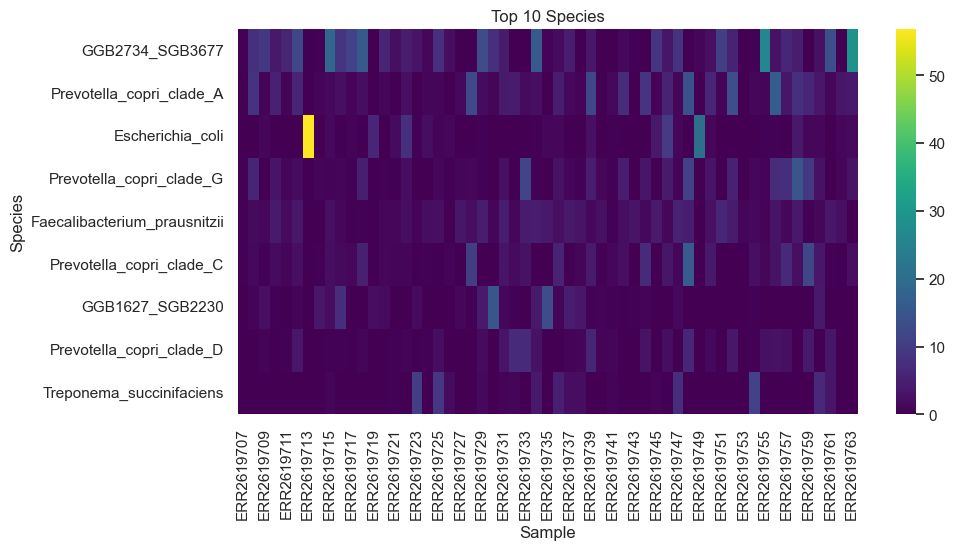

In [308]:

topSpeciesDf = mpaSpeciesDf.loc[top_10_species.index]

# Drop "unclassified" row
topSpeciesDf = topSpeciesDf.drop('UNCLASSIFIED') 

# Heatmap
sns.heatmap(topSpeciesDf, cmap='viridis').set(
    title='Top 10 Species', xlabel='Sample', ylabel='Species')

Apparently a sample is quite rich in *E. coli*...

## HuMANN table

We can finally import one of the output of humann

In [309]:

hu_url = 'https://raw.githubusercontent.com/quadram-institute-bioscience/biobakery-2024/main/datasets/lokmer_pathabundance.tsv.gz'
humannDf = pd.read_csv(hu_url, compression='gzip', sep='\t', header=0)

humannDf.set_index("# Pathway", inplace=True)
# Rename the index to simply "Pathway"
humannDf.index.name = 'Pathway'

# Strip "_1_Abundance" from all columns
humannDf.columns = humannDf.columns.str.replace('_1_Abundance', '')

humannDf.head()

,ERR2619707,ERR2619708,ERR2619709,ERR2619710,ERR2619711,ERR2619712,ERR2619713,ERR2619714,ERR2619715,ERR2619717,ERR2619718,ERR2619719,ERR2619720,ERR2619724,ERR2619725,ERR2619726,ERR2619728,ERR2619729,ERR2619730
Pathway,,,,,,,,,,,,,,,,,,,
UNMAPPED,6.192329e+06,6.216055e+06,7.841818e+06,4.517717e+06,5.242540e+06,4.327137e+06,1.358372e+06,4.487376e+06,5.766362e+06,9.233998e+06,5.338710e+06,2.584634e+06,5.579655e+06,4.492194e+06,7.736167e+06,9.583500e+06,7.734464e+06,5.224053e+06,5.730943e+06
UNINTEGRATED,2.308979e+06,7.055302e+06,4.636209e+06,4.800412e+06,2.554475e+06,3.785976e+06,1.654607e+07,1.769686e+06,4.574623e+06,4.211182e+06,4.630794e+06,2.054961e+06,3.893573e+06,5.161325e+06,6.877710e+06,4.206402e+06,8.209068e+06,4.896104e+06,4.210069e+06
UNINTEGRATED|g__Agathobaculum.s__Agathobaculum_butyriciproducens,1.920500e+04,9.411855e+03,0.000000e+00,1.532966e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.257086e+03,0.000000e+00,0.000000e+00,0.000000e+00,2.750525e+04,0.000000e+00,0.000000e+00,1.360831e+04,4.869778e+04
UNINTEGRATED|g__Alistipes.s__Alistipes_shahii,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,8.285370e+03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
UNINTEGRATED|g__Alistipes.s__Alistipes_sp_CAG_435,8.772303e+04,3.841891e+04,2.979604e+05,2.583849e+04,0.000000e+00,2.403983e+04,0.000000e+00,1.643397e+05,1.694599e+05,0.000000e+00,0.000000e+00,3.407848e+04,1.000933e+05,0.000000e+00,6.663588e+04,0.000000e+00,3.001520e+04,2.164640e+05,9.378955e+05


Humann provides tools to manage their output files. In particular we used

* **humann_join_tables** to join multiple tables and producing the raw output we just imported:
  *  `humann_join_tables -i humann_3.7/*/*_pathabundance.tsv -o lokmer_pathabundance.tsv`
* **humann_renorm_table** to make a table normalized to relative abundances:
  * `humann_renorm_table --units relab --input lokmer_pathabundance.tsv --output lokmer_pathabundance_relab.tsv`
* **humann_split_stratified_table** to split the table into two files (one stratified and one unstratified):
  * `humann_split_stratified_table --input lokmer_pathabundance_relab.tsv  --output lokmer-pathab`


In [310]:

unstratified_url = 'https://raw.githubusercontent.com/quadram-institute-bioscience/biobakery-2024/main/datasets/lockmer_pathabundance_relab_unstratified.tsv'
unstratifiedDf = pd.read_csv(unstratified_url, sep='\t', header=0)
unstratifiedDf.set_index("# Pathway", inplace=True)
unstratifiedDf.index.name = 'Pathway'
unstratifiedDf.columns = unstratifiedDf.columns.str.replace('_1_Abundance', '')

unstratifiedDf.head()

,ERR2619707,ERR2619708,ERR2619709,ERR2619710,ERR2619711,ERR2619712,ERR2619713,ERR2619714,ERR2619715,ERR2619717,ERR2619718,ERR2619719,ERR2619720,ERR2619724,ERR2619725,ERR2619726,ERR2619728,ERR2619729,ERR2619730
Pathway,,,,,,,,,,,,,,,,,,,
UNMAPPED,0.704882,0.444867,0.598882,0.457845,0.642488,0.507442,6.946530e-02,0.689434,0.528797,0.660519,0.510200,0.532334,0.565726,0.439072,0.499024,0.666817,0.466655,0.488641,0.550407
UNINTEGRATED,0.262834,0.504930,0.354069,0.486494,0.313058,0.443980,8.461440e-01,0.271892,0.419510,0.301231,0.442547,0.423242,0.394773,0.504474,0.443649,0.292680,0.495290,0.457965,0.404340
1CMET2-PWY: folate transformations III (E. coli),0.000273,0.000393,0.000323,0.000429,0.000344,0.000369,3.078620e-04,0.000343,0.000323,0.000249,0.000451,0.000225,0.000343,0.000378,0.000380,0.000210,0.000310,0.000413,0.000473
3-HYDROXYPHENYLACETATE-DEGRADATION-PWY: 4-hydroxyphenylacetate degradation,0.000000,0.000000,0.000000,0.000004,0.000000,0.000000,7.070680e-05,0.000000,0.000000,0.000004,0.000000,0.000000,0.000000,0.000018,0.000008,0.000000,0.000003,0.000003,0.000001
AEROBACTINSYN-PWY: aerobactin biosynthesis,0.000000,0.000002,0.000000,0.000000,0.000000,0.000000,8.573660e-07,0.000000,0.000000,0.000000,0.000000,0.000034,0.000000,0.000000,0.000000,0.000000,0.000000,0.000003,0.000004


In [311]:
# What are the top 10 pathways in the humannDf?

# Remove all index rows starting with UNINTEGRATED
humannDf = humannDf[~humannDf.index.str.startswith('UNINTEGRATED')]

total_abundance = humannDf.sum(axis=1)

# Sort the pathways by their total abundance in descending order
sorted_abundance = total_abundance.sort_values(ascending=False)

# Select the top 10 pathways
top_10_pathways = sorted_abundance.head(10)
top_10_pathways

Pathway
UNMAPPED                                                     1.091880e+08
DTDPRHAMSYN-PWY: dTDP-&beta;-L-rhamnose biosynthesis         1.567144e+05
PWY-1042: glycolysis IV                                      1.271677e+05
VALSYN-PWY: L-valine biosynthesis                            1.215600e+05
TRNA-CHARGING-PWY: tRNA charging                             1.189735e+05
PWY-7238: sucrose biosynthesis II                            1.155263e+05
PWY-7221: guanosine ribonucleotides de novo biosynthesis     1.128961e+05
ILEUSYN-PWY: L-isoleucine biosynthesis I (from threonine)    1.120368e+05
PWY-5686: UMP biosynthesis I                                 1.118539e+05
PWY-7790: UMP biosynthesis II                                1.114541e+05
dtype: float64

Humann also provides scripts to plot some features.
For example:
```bash
humann_barplot --input ockmer_pathabundance_relab_stratified.tsv --focal-feature DTDPRHAMSYN-PWY -o figure.png
```

would plot
![plot](../assets/lokmer-DTDPRHAMSYN-PWY.png)